In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime

# statsmodels has all you need
import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (11,6)
%config IPCompleter.greedy=True

# What is time series data and why do we care?

- **"Cross Sectional" Data**: multiple entities observed at a single point in time
    - Example: our college GPA exercise from the previous regression sessions
- **"Time Series" Data**: a single entity observed over multiple time periods
    - We often refer to time series of *aggregate* data
    - Example: GDP
    - Example: Flexport shipment volume
- **"Panel" Data**: multiple entities observed over multiple time periods
    - Example: survey panels
    - Example: Flexport shipment volume *by client*
    
[Time series *analysis*](https://en.wikipedia.org/wiki/Time_series) is the practice of extracting patterns or statistics from time series data. From this analysis we can derive *forecasts* of future time periods, which have a pretty clear business use case at Flexport.

The phrase "forecast" gets thrown around a lot by lay business users:

<img src="https://nbbumnd0bj-flywheel.netdna-ssl.com/wp-content/uploads/2015/11/you-keep-using-that-word.jpg">

For our purposes, we define a "forecast" as:
- **A projection of the value of a time series in future, unobserved, periods based on currently observable data**

# What are we trying to achieve with this session?
Time series problems come up all of the time! It's helpful to understand:
- The basics of time series data, and foundational knowledge that is crucial to modeling against it
- Basic time series forecasting methods

With this knowledge, you should have an idea of how time series forecasting works and what to expect from it (no over-promising to stakeholders). From there, there's a lot more to dive into once you know the basics.

## Hey, I thought this was a Python session - I didn't show up to learn econometrics
Technically this is a Python session, and we'll present all of these examples via code. But, I won't be focusing on live-coding exercises or digging too deep into the examples. Let's use this opportunity to build on our previous stats and Python knowledge and get a sense of what `statsmodels` is capable of


## Random note: forecasting is not predicting the future, macroeconomics is not sexy

I'll make this point early on, and we'll revisit it across this session: generating a time series forecast does not constitute magical powers to divine future events - it is merely a method to rationalize short-term expectations as a result of recently observed patterns or "shocks".



## To cover

In this session:
1. Stationarity and trends
2. Testing for stationarity
3. The AR(1) model and forecasting

Stretch/for the future:
1. Out-of-sample forecast evaluation
1. The AR(n) model
2. The MA, ARMA, and ARIMA models
3. VARs

## Let's start with US GDP

We'll download one of our example time series, US GDP. The Federal Reserve Bank of St. Louis maintains a public database of economic data, ["FRED"](https://fred.stlouisfed.org/), which is comprehensive and easy to navigate. [Here's the page for real, seasonally adjusted GDP.](https://fred.stlouisfed.org/series/GDPC1)

### Notation

A time series $y$ is typically subscripted with $t$ to indicate the value of the time series in a given period:
$$y_{t}$$

We can use this notation to indicate lags, leads, and change:
$$y_{t-1}$$
$$y_{t+1}$$
$$\Delta y_{t} = y_{t} - y_{t-1}$$

In [2]:
# getting data from FRED's very flexible URL
FRED_LINK = "https://fred.stlouisfed.org/graph/fredgraph.csv"

DEFAULT_PARAMS = {
    'id': 'GDPC1',
    'freq': 'Quarterly',
    'vintage_date': date.today().strftime('%Y-%m-%d'),
    'revision_date': date.today().strftime('%Y-%m-%d'),
    'nd': '1947-01-01'
}

def download_fred_series(params=DEFAULT_PARAMS) -> pd.Series:
    """
    pass specified parameters into a FRED URL and download resulting CSV
    unpack into a single time series
    """
    url_params = '&'.join(
        ['='.join(x) for x in params.items()])
    full_url = '{}?{}'.format(FRED_LINK, url_params)
    
    data = pd.read_csv(full_url)
    
    data.columns = [x.lower() for x in data.columns]
    data['date'] = pd.to_datetime(data['date'])
    
    return data.set_index('date')[params['id'].lower()]

In [3]:
gdp = download_fred_series()

Text(0, 0.5, 'Billions of 2012 dollars')

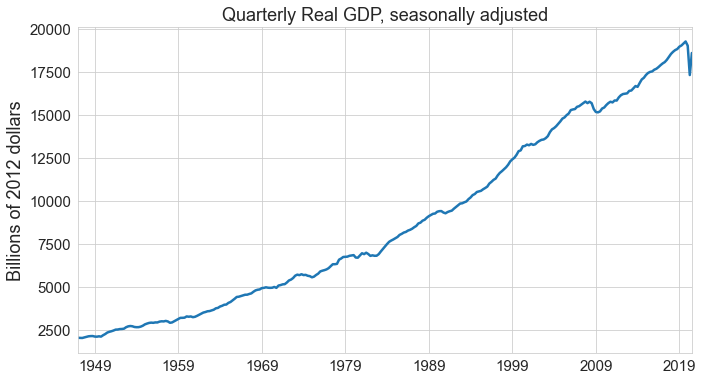

In [4]:
gdp.plot(linewidth=2.5)
plt.yticks(size=15)
plt.xticks(size=15)
plt.xlabel('')

plt.title('Quarterly Real GDP, seasonally adjusted', size=18)

plt.ylabel('Billions of 2012 dollars', size=18)

In [6]:
gdp.tail()

date
2019-07-01    19141.744
2019-10-01    19253.959
2020-01-01    19010.848
2020-04-01    17302.511
2020-07-01    18583.501
Name: gdpc1, dtype: float64

## If you wanted to make a guess at GDP for the fourth quarter of 2020, how would you do that?

Let's start by pretending this isn't a time series, but rather a cross-sectional series of data. If we had a cross-sectional series, what's the *simplest, most naive estimate* we could provide based on that data?

We'd calculate the *mean*, and this would be our expected value.

Does this really work for a time series like GDP?

Text(0, 0.5, 'Billions of 2012 dollars')

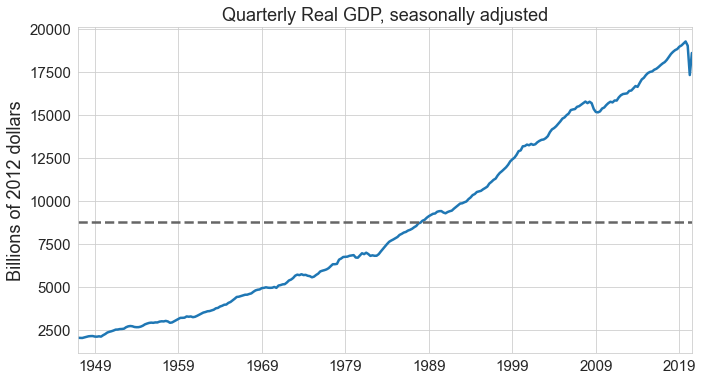

In [7]:
gdp.plot(linewidth=2.5)
plt.axhline(gdp.mean(), linewidth=2.5, linestyle='dashed', color='#666666')

plt.yticks(size=15)
plt.xticks(size=15)
plt.xlabel('')

plt.title('Quarterly Real GDP, seasonally adjusted', size=18)

plt.ylabel('Billions of 2012 dollars', size=18)

Using the mean as a naive estimate of GDP doesn't work, because the series is generally increasing over time. Our data points aren't unordered as they would be in a cross-section, so the *time* of an observation provides addtional information that influences the expected value.

In time series jargon, the series is not ***stationary***. A stationary process is one that has the same mean and variance across time periods (per [Wikipedia](https://en.wikipedia.org/wiki/Stationary_process)). 

We can see above that:
- The average GDP has changed drastically over the last 70 years. Earlier periods are below the all-time average, while later periods are above it
- As GDP has increased, variance around the all-time mean has also changed

We don't want to model or analyze a time series that is not stationary, because it will lack a lot of the properties that we associate with cross-sectional data, and because any patterns that we discover will be unstable and subject to change over time.

## Addressing stationarity (which is an actual word)

How do we deal with a time series that we want to analyze that is non-stationary? **We apply a transformation to make it stationary**

The most common transformations are:
- Taking the first difference, or the difference between each period and the directly preceding period:
$$\Delta y_{t} = y_{t} - y_{t-1}$$
- Taking the percent change, or the first difference divided by the value in the preceding period
$$ \frac{y_{t} - y_{t-1}}{y_{t-1}} $$

In [8]:
# easily accomplished with pandas methods
# note: make sure your data is sorted!
gdp_diff = gdp.diff()
gdp_pct = gdp.pct_change()

# for plotting, I truncate to omit COVID craziness. We'll revisit that later!
gdp_diff_trunc = gdp_diff.loc[:'2019-10-01']
gdp_pct_trunc = gdp_pct.loc[:'2019-10-01']

Text(0, 0.5, 'Billions of 2012 dollars')

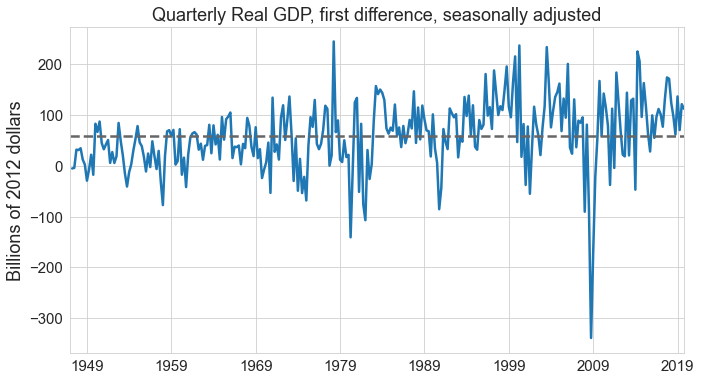

In [9]:
gdp_diff_trunc.plot(linewidth=2.5)
plt.axhline(gdp_diff_trunc.mean(), linewidth=2.5, linestyle='dashed', color='#666666')

plt.yticks(size=15)
plt.xticks(size=15)
plt.xlabel('')

plt.title('Quarterly Real GDP, first difference, seasonally adjusted', size=18)

plt.ylabel('Billions of 2012 dollars', size=18)

Text(0, 0.5, 'Billions of 2012 dollars')

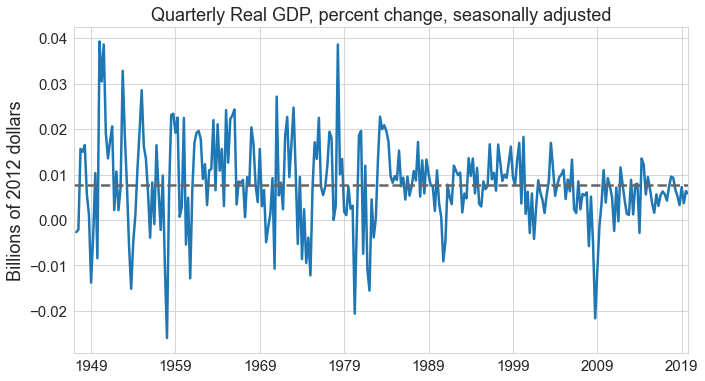

In [10]:
gdp_pct_trunc.plot(linewidth=2.5)
plt.axhline(gdp_pct_trunc.mean(), linewidth=2.5, linestyle='dashed', color='#666666')

plt.yticks(size=15)
plt.xticks(size=15)
plt.xlabel('')

plt.title('Quarterly Real GDP, percent change, seasonally adjusted', size=18)

plt.ylabel('Billions of 2012 dollars', size=18)

Eyeball testing observations:
- The **first-difference** still seems to exhibit a change in mean over time, as well as an increase in variance
- The **percent-change** has the opposite pattern: A decrease in mean and variance over time
- In both cases, the transformed series is much closer to being stationary than the un-transformed (level) series

What kind of assumptions are we making with each of these?
- When we assert that the mean of the first difference is stable over time, we are suggesting that the series follows **a linear trend** (the increase in each period is expected to be the same)
- When we assert that the mean of the percent change is stable over time, we are suggesting that the series is increasing at an increasing rate

Think about this in the context of GDP:
- We don't really expect the first difference to be mean-stable over time, because GDP is much bigger today - we might expect bigger changes in each period as well
- The percent change series, on the other hand, is prone to wild swings in older data, when GDP was lower

We have one more trick up our sleeve: **truncating our sample**

Economists have called the period since the mid 1980's ["The Great Moderation"](https://en.wikipedia.org/wiki/Great_Moderation), theorizing that once everyone came down from their coke bender the economy really got on track. Some even thought that we would not experience any large recessions ever again (note: economists are idiots). 

Regardless of the validity of parts of this argument, it's reasonable to conclude that GDP growth has exhibited starkly different patterns pre- and post-1985. It's also reasonable to expect that any time series will not exhibit the same patterns throughout history, and we shouldn't draw inference on future periods using *too much* history, lest we leverage data that is not truly generalizable

Text(0, 0.5, 'Billions of 2012 dollars')

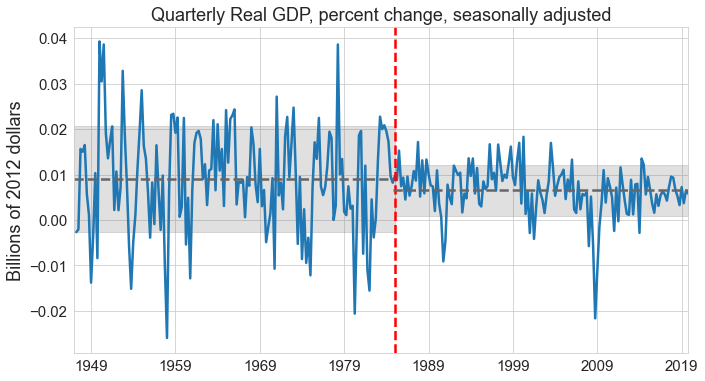

In [11]:
MODERATION_START = '1985-01-01'
gdp_pct_trunc.plot(linewidth=2.5)

plt.axvline(MODERATION_START, linestyle='dashed', linewidth=2.5, color='red')
pre = gdp_pct_trunc.loc[:MODERATION_START]
post = gdp_pct_trunc.loc[MODERATION_START:]

pre_mean = pre.mean()
pre_std = pre.std()
post_mean = post.mean()
post_std = post.std()

plt.axhline(pre_mean, xmax=0.52, linewidth=2.5, linestyle='dashed', color='#666666')
plt.axhline(post_mean, xmin=0.52, linewidth=2.5, linestyle='dashed', color='#666666')
plt.fill_between(pre.index, 
                 pd.Series(pre_mean - pre_std, index=pre.index),
                 pd.Series(pre_mean + pre_std, index=pre.index), color='#666666', alpha=0.2)
plt.fill_between(post.index, 
                 pd.Series(post_mean - post_std, index=post.index),
                 pd.Series(post_mean + post_std, index=post.index), color='#666666', alpha=0.2)

plt.yticks(size=15)
plt.xticks(size=15)
plt.xlabel('')

plt.title('Quarterly Real GDP, percent change, seasonally adjusted', size=18)

plt.ylabel('Billions of 2012 dollars', size=18)

In [12]:
# let's stick with the post-moderation series
gdp_mod = gdp.loc[MODERATION_START:'2020-01-01']
gdp_pct_mod = gdp_pct_trunc.loc[MODERATION_START:]
gdp_diff_mod = gdp_diff_trunc.loc[MODERATION_START:]

### Testing for stationarity - beyond the eyeball test

To be diligent, we should use an actual statistical test to discern stationarity. Good options include the [Dickey-Fuller (DF) test](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test) as well as its more complex extension, the [augmented Dickey-Fuller (ADF) test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test). These are easy to run using statsmodels.

The nature of these tests will be easier to understand once we cover autoregressive models below. In the basic Dickey-Fuller test, we are testing the null hypothesis that the time series $y_{t}$ is stationary by estimating the following model:

$$\Delta y_{t} = \delta y_{t-1} + u_{t} $$

If the coefficient $\delta$ is equal to zero, then $\Delta y_{t} = u_{t}$, which means that the series is expected to change by some amount $u_{t}$ in each period. If this is the case, then the series $y_{t}$ will not converge to a mean value and is not considered stationary.

The *augmented* test includes additional lag terms: 
$$y_{t-2}, y_{t-3}, ... , y_{t-n}$$

Which makes the test more robust to more complex time series properties.

In [13]:
# let's run the augmented dickey fuller test
# first, let's use the level series
#  by default, the statsmodels implementation will use the AIC to determine the optimal number of lag terms
sm.tsa.adfuller(gdp_mod)

(-0.3412358206941736,
 0.9194576605194328,
 2,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 1461.7387092195079)

In [14]:
# that resultset is a nightmare, let's write a function to print it nicely
def print_adf(y, maxlag=None, autolag='AIC'):
    """Runs augmented dickey fuller test and prints nice results"""
    result = sm.tsa.adfuller(y, maxlag=maxlag, autolag=autolag)
    print(
        """
        Test stat:  {:,.3f}
        P-value:    {:,.3f}
        Lags:       {:,.0f}
        N. obs:     {:,.0f}
        """.format(result[0], result[1], result[2],
                   result[3]))

In [15]:
print_adf(gdp_mod)


        Test stat:  -0.341
        P-value:    0.919
        Lags:       2
        N. obs:     138
        


In [16]:
# now let's try it with the first difference
print_adf(gdp_diff_mod)


        Test stat:  -5.385
        P-value:    0.000
        Lags:       1
        N. obs:     138
        


In [17]:
print_adf(gdp_pct_mod)


        Test stat:  -5.094
        P-value:    0.000
        Lags:       1
        N. obs:     138
        


Based on the results of the dickey-fuller test, we can consider both the first difference and percent change series to be stationary (after the "great moderation")

## Now tell me how to predict the future

Now that we've transformed GDP into a stationary time series, we already have a naive estimate for future growth: the mean of our stationary time series.

Here, we can introduce a distinction between **short-term** and **long-term** forecasting.

If you asked me 20 years ago what GDP growth would be this year, my best guess would simply be the average of my time series (our stationary series is a first difference or percent change, but we could derive a forecast for GDP level based on this). 

Of course that would have been a terrible guess for this year, but if you tested this heuristic across many different time periods, you'd get a result that is roughly unbiased. **We expect a stationary time series to revert to the mean in the long term, and this is pretty much the best we can do for long-range forecasting**

In [18]:
# construct a ten-year ahead forecast
forecast_diff = (gdp_diff_mod.cumsum() / pd.notnull(gdp_diff_mod).cumsum()).shift(40)
forecast_level = gdp_mod.shift(40) + forecast_diff * 40

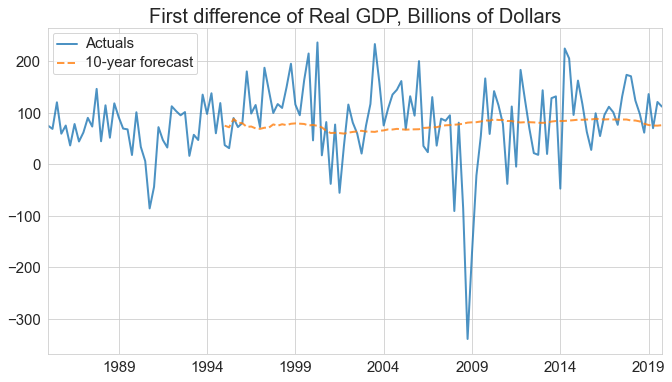

In [25]:
gdp_diff_mod.plot(linewidth=2, alpha=0.8)
forecast_diff.plot(linestyle='dashed', linewidth=2, alpha=0.8)

plt.yticks(size=15)
plt.title('First difference of Real GDP, Billions of Dollars', size=20)
plt.xticks(size=15)
plt.xlabel('')

leg = plt.legend(['Actuals', '10-year forecast'])
for i in leg.get_texts():
    i.set_size(15)

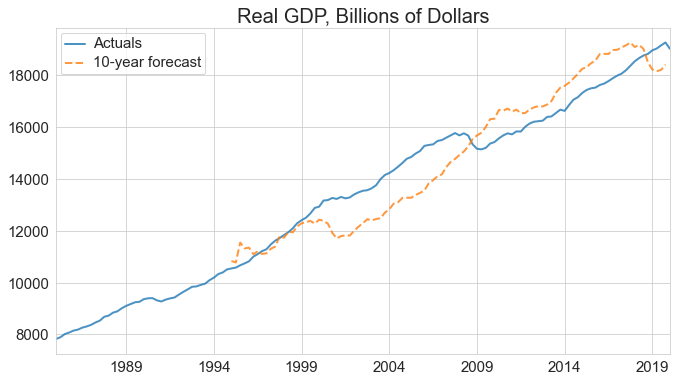

In [26]:
gdp_mod.plot(linewidth=2, alpha=0.8)
forecast_level.plot(linestyle='dashed', linewidth=2, alpha=0.8)

plt.yticks(size=15)
plt.title('Real GDP, Billions of Dollars', size=20)
plt.xticks(size=15)
plt.xlabel('')

leg = plt.legend(['Actuals', '10-year forecast'])
for i in leg.get_texts():
    i.set_size(15)

### But what about over the short term?

After accounting for long term trends, the real impetus of time series analysis is to understand how the series responds to short term shocks.

Notice the recessions in the plots above? These are big events, and we are interested in how our GDP time series is expected to revert to the mean after them. We are *not*, however, trying to actually predict recessions or other "black swan" events (again, economists aren't that smart)

### Basic modeling techniques: the AR(1) model

The most intuitive way to model a stationary time series is to run a regression of the series on its past values - referred to as an *autoregressive model*. 

$$y_{t} = \alpha + \beta y_{t-1} + \epsilon_{t} $$

We refer to $y_{t-1}$ as the "lag term" in this model, and $\beta$ as the coefficient on the lag term

- If our series is elevated in the previous period, do we expect it to remain elevated? In this case, $\beta$ above is positive, and this would be an example of *positive serial correlation*
- If our series is elevated in the previous period, do we expect it to rebound in the opposite direction? In this case, $\beta$ above is negative, and this would be an example of *negative serial correlation*

Text(0.5, 0, 'GDP difference, previous period')

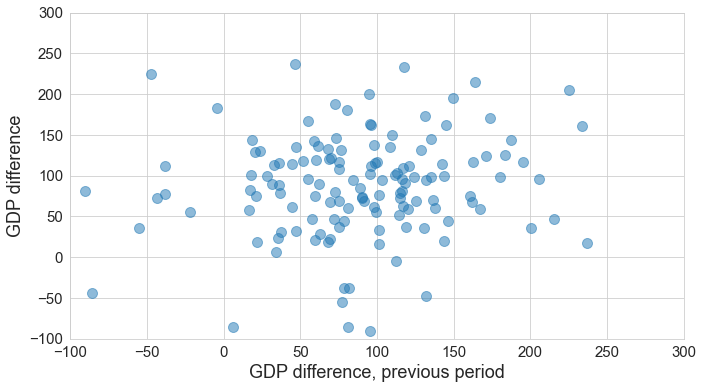

In [33]:
plt.scatter(gdp_diff_mod.shift(1), gdp_diff_mod, s=100, alpha=0.5)
plt.xlim(-100, 300)
plt.ylim(-100, 300)

plt.yticks(size=15)
plt.ylabel('GDP difference', size=18)
plt.xticks(size=15)
plt.xlabel('GDP difference, previous period', size=18)

In [34]:
# running this regression is pretty simple - let's take a look
gdp_diff_regression_data = pd.DataFrame(gdp_diff_mod)

# add intercept
gdp_diff_regression_data['intercept'] = 1

# take the lag - pretty simple with pandas
gdp_diff_regression_data['gdpc1_l1'] = gdp_diff_regression_data.gdpc1.shift(1)

ar1 = sm.OLS(endog=gdp_diff_regression_data.gdpc1, 
             exog=gdp_diff_regression_data[['intercept', 'gdpc1_l1']],
             missing='drop').fit()

ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gdpc1   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     19.24
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           2.28e-05
Time:                        10:45:54   Log-Likelihood:                -788.15
No. Observations:                 139   AIC:                             1580.
Df Residuals:                     137   BIC:                             1586.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     53.4520      8.888      6.014      0.000      35.876      71.028
gdpc1_l1       0.3511      0.080      4.386      0.000       0.193       0.509
==============================================================================
Omnibus:                       40.626   Durbin-Watson:                   2.141
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              140.393
Skew:                          -1.026   Prob(JB):                     3.27e-31
Kurtosis:                       7.475   Cond. No.                         165.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

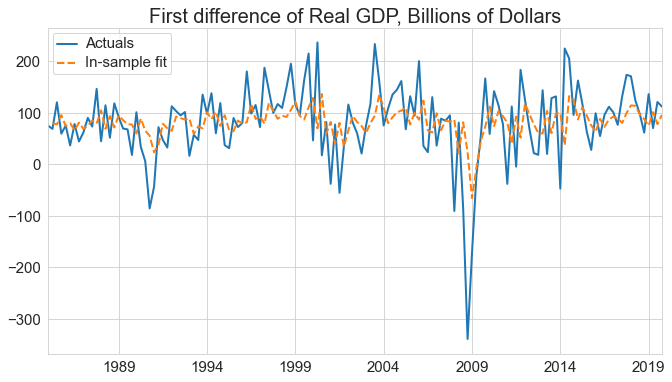

In [38]:
# in-sample fit
gdp_diff_regression_data.gdpc1.plot(linewidth=2)
ar1.predict(gdp_diff_regression_data[['intercept', 'gdpc1_l1']]).plot(linewidth=2, linestyle='dashed')

plt.yticks(size=15)
plt.title('First difference of Real GDP, Billions of Dollars', size=20)
plt.xticks(size=15)
plt.xlabel('')

leg = plt.legend(['Actuals', 'In-sample fit'])
for i in leg.get_texts():
    i.set_size(15)

The lagged term has *some* explanatory power, as evidenced by the $R^{2}$ of 0.1, but it's not a great fit.

We can see that the coefficient is positive, which means that a period of elevated GDP growth is follwed by similarly elevated (but slightly lower) growth in the following period:

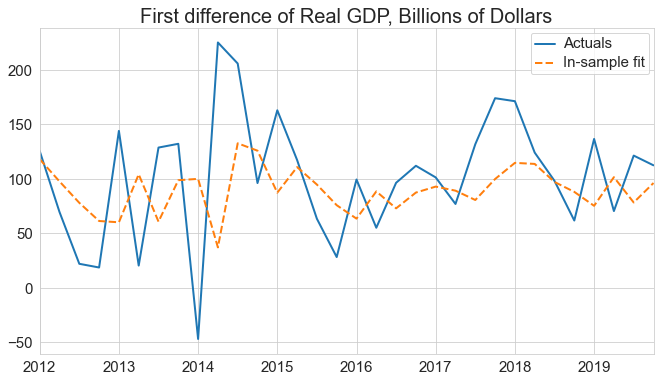

In [39]:
gdp_diff_regression_data.gdpc1.loc['2012-01-01':].plot(linewidth=2)
ar1.predict(gdp_diff_regression_data[['intercept', 'gdpc1_l1']]).loc['2012-01-01':].plot(linestyle='dashed', linewidth=2)

plt.yticks(size=15)
plt.title('First difference of Real GDP, Billions of Dollars', size=20)
plt.xticks(size=15)
plt.xlabel('')

leg = plt.legend(['Actuals', 'In-sample fit'])
for i in leg.get_texts():
    i.set_size(15)

This also means that we'll never anticipate any other kinds of movements: growth in the opposite direction, or growth that is increasing.

### Forecasting
Of course, the in-sample fit isn't really that interesting - what we want to do is leverage this relationship in order to predict future periods. But how does this work with the autoregressive model?

For an AR(1) model, we get one period of the forecast "for free" by using data from the current period:

$$\hat{y}_{t+1} = \alpha + \beta y_{t} $$

This is because in $t+1$, the lagged value is the value in $t$. But how do we forecast for $t+2$ and beyond? Since we haven't actually observed $y_{t+1}$, we can't compute the fitted value normally. Instead, we use the fitted value $\hat{y}_{t+1}$ to impute:

$$\hat{y}_{t+1} = \alpha + \beta \hat{y}_{t+1} = \alpha + \beta (\alpha + \beta y_{t})$$

Which, of course, we can generalize to any future period $t+n$:

$$\hat{y}_{t+n} = \alpha + \beta \hat{y}_{t+n-1}$$

As $n$ increases, we expect the signal from $y_{t}$ to decay, and our forecast to revert to the mean.

However... **what happens if $\beta$ is greater than one or less than negative one?** In this case, the time series would diverge from the mean. This is what we were testing earlier with the Dickey-Fuller test! If you try to construct a time series forecast with such a coefficient, you're gonna have a bad time.

In [40]:
# playing around with the autoregressive equation - here's a function that will grow the forecast

def quarterly_autoregressive_forecast(series, beta=0.1, alpha=None, steps_ahead=10):
    # add extra periods to the series index
    extended_idx = pd.date_range(
        start=series.index.min(),
        end=series.index.max() + pd.DateOffset(months=steps_ahead*3), freq='QS')
    extended_series = series.reindex(extended_idx)
    
    # if alpha isn't specified, calculate it as a function of the chosen beta and data
    if not alpha:
        alpha = (1 - beta) * series.mean()
    
    # iterate over future periods
    #  compute the fitted value
    #  impute using the fitted value from the previous period if necessary
    for qx in pd.date_range(start=series.index.max() + pd.DateOffset(months=3),
                            end=extended_idx.max(), freq='QS'):
        q_prev = qx - pd.DateOffset(months=3)
        extended_series.loc[qx] = alpha + extended_series.loc[q_prev] * beta
    
    
    return extended_series

In [41]:
b_10 = quarterly_autoregressive_forecast(
    gdp_diff_mod.loc[:'2016-01-01'], beta=0.1)
b_50 = quarterly_autoregressive_forecast(
    gdp_diff_mod.loc[:'2016-01-01'], beta=0.5)
b_110 = quarterly_autoregressive_forecast(
    gdp_diff_mod.loc[:'2016-01-01'], beta=1.1)

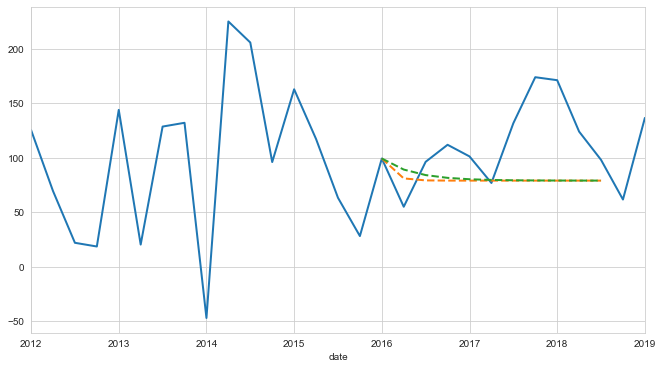

In [44]:
gdp_diff_mod.loc['2012-01-01':'2019-03-01'].plot(linewidth=2)
b_10.loc['2016-01-01':].plot(linewidth=2, linestyle='dashed')
b_50.loc['2016-01-01':].plot(linewidth=2, linestyle='dashed')
#b_110.loc['2016-01-01':].plot(linewidth=2, linestyle='dashed')

In [45]:
b_n10 = quarterly_autoregressive_forecast(
    gdp_diff_mod.loc[:'2016-01-01'], beta=-0.1)
b_n80 = quarterly_autoregressive_forecast(
    gdp_diff_mod.loc[:'2016-01-01'], beta=-0.8)
b_n110 = quarterly_autoregressive_forecast(
    gdp_diff_mod.loc[:'2016-01-01'], beta=-1.1)

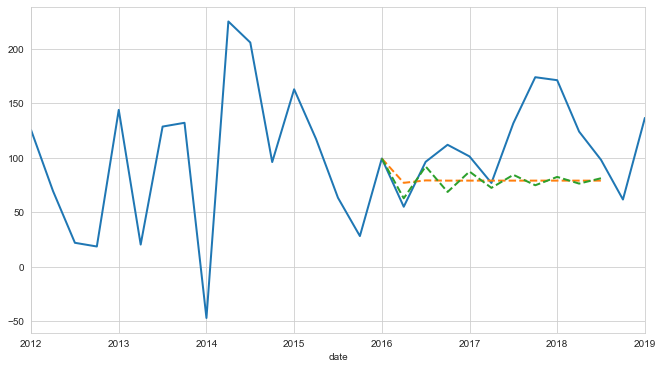

In [48]:
gdp_diff_mod.loc['2012-01-01':'2019-03-01'].plot(linewidth=2)
b_n10.loc['2016-01-01':].plot(linewidth=2, linestyle='dashed')
b_n80.loc['2016-01-01':].plot(linewidth=2, linestyle='dashed')
#b_n110.loc['2016-01-01':].plot(linewidth=2, linestyle='dashed')

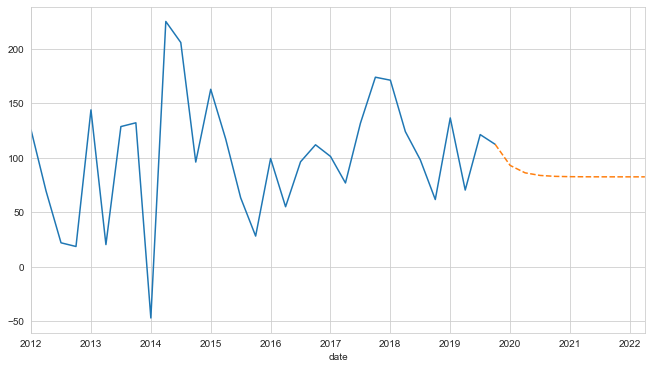

In [49]:
forecast = quarterly_autoregressive_forecast(
    gdp_diff_mod, alpha=ar1.params.intercept, beta=ar1.params.gdpc1_l1)

gdp_diff_mod.loc['2012-01-01':].plot()
forecast.loc['2019-10-01':].plot(linestyle='dashed')

### Evaluating forecasts

We constructed a forecast for 2020-2022, based on data through the end of 2019. If we were looking at this forecast at the end of 2019, we might think it looks pretty reasonable, but reality looked a lot different...

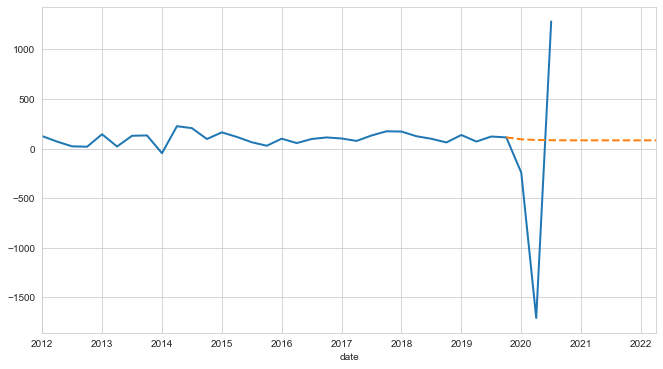

In [58]:
forecast = quarterly_autoregressive_forecast(
    gdp_diff_mod, alpha=ar1.params.intercept, beta=ar1.params.gdpc1_l1)
gdp.diff().loc['2012-01-01':].plot(linewidth=2)
forecast.loc['2019-10-01':].plot(linestyle='dashed', linewidth=2)

So... time series forecasting wouldn't exactly have allowed us to predict COVID-19. Like we covered earlier, we don't expect these methods to predict future "shocks" - we're more concerned about how the model *reacts* to those shocks. The GDP decline (and subsequent rebound) associated with COVID-19 were also unprecedented, and not something a time series model could have generalized from prior data.

What happens if we construct our forecast in the immediate aftermath of the Q2 decline?

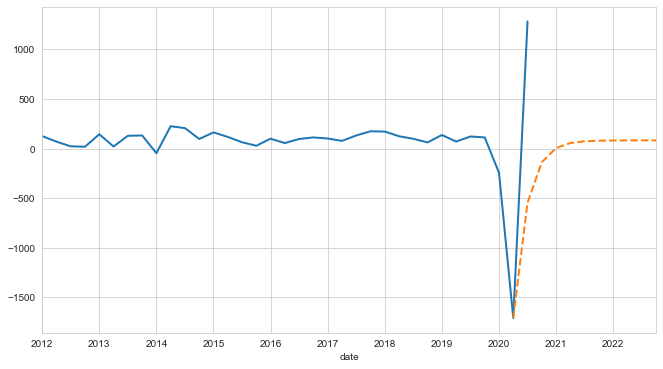

In [55]:
forecast = quarterly_autoregressive_forecast(
    gdp.diff().loc[:'2020-04-01'], alpha=ar1.params.intercept, beta=ar1.params.gdpc1_l1)
gdp.diff().loc['2012-01-01':].plot(linewidth=2)
forecast.loc['2020-04-01':].plot(linestyle='dashed', linewidth=2)

Because our lag coefficient is positive, we expected growth to remain below average in the subsequent periods - but not as low as the initial shock. In reality, we saw a rebound that was more consistent with a *negative* coefficient. Nevertheless, we could be pretty confident that growth in the period after the large negative shock would be closer to the long-term average than the period before.

Why might our model still perform poorly in this situation? Again, the dynamics of the COVID-19 pandemic and its effect on the economy were unprecedented. We may normally expect the effects of a recession to linger and slowly improve, and our model based on historical data would reflect this. But with various sectors closing and re-opening abruptly, we saw a different pattern.

# What's next?

- Out of sample forecast evaluation/validation (see below)
- Adding additional lags to improve the AR model
    - AR(2), AR(3), ..., AR(n)
- The moving average (MA) model
- ARMA and ARIMA models, which combine the autoregressive model with the moving average model
    - This is the most commonly used "out-of-the-box" time series model, so it pays to have a working understanding
- Creating multivariate models
- Vector Autogression (VAR) models

# Out of sample evaluation

We've already briefly assessed in-sample fit. As with cross-sectional models, it's also imperative that we evaluate the model *out-of-sample*. We've already done this in the above example, by computing a forecast using older data and comparing it to the actual outcome. More generally, how do we strucuture this sort of analysis?

With a cross-sectional model, we would run an out-of-sample evaluation by holding out a random subset of the data as a test set before fitting a model. Why would this be inappropriate for a time series model? Well, our data now has an explicit ordering - we wouldn't want to *test* our model using data that we would have observed at the time the model was estimated. We also want to be able to test the accuracy of our recursive forecasts many steps ahead.

(Note: this is also a reasonable principle for testing cross-sectional prediction models)

There are two varieties of out-of-sample testing to consider:
- **pseudo-out-of-sample** testing: we estimate a single model using all data points available, then generate vintage forecasts
- **true-out-of-sample** testing: for each vintage period, we estimate the model with only data available at that time. Then, we generate a vintage forecast



In [109]:
# writing some code for out of pseudo- and true-out-of-sample testing

def pseudo_out_of_sample_forecasts(data: pd.Series, alpha: float, beta: float,
                                   steps_ahead:int=10,
                                   eval_start: date = date(2010,1,1), 
                                   eval_end=date(2019,10,1)) -> pd.DataFrame:
    """
    use a previously estimated ``alpha`` and ``beta`` from an AR(1) model
      to generate vintage forecasts
    returns a dataframe
    """
    evaluation_range = pd.date_range(start=eval_start, end=eval_end, freq='QS')
    total_range = pd.date_range(start=eval_start, 
                                end=eval_end + pd.DateOffset(months=3*steps_ahead), freq='QS')
    results = pd.DataFrame(index=evaluation_range, columns=total_range)
    results.index.name = 'vintage'
    for qx in evaluation_range:
        vintage_data = data.loc[:qx]
        vintage_fore = quarterly_autoregressive_forecast(
            vintage_data, alpha=alpha, beta=beta, steps_ahead=steps_ahead)
        results.loc[qx] = vintage_fore
        
        
        
    long_results = pd.melt(results.reset_index(), id_vars='vintage', var_name='date')
    long_results = long_results.loc[pd.notnull(long_results['value'])]
    long_results['horizon'] = np.round((long_results.date - long_results.vintage) / np.timedelta64(3, 'M'))
    long_results = long_results.set_index('date').join(data)
    long_results['error'] = (long_results[data.name] - long_results['value']).astype(float)
    
    return long_results

In [115]:
results = pseudo_out_of_sample_forecasts(gdp_diff_mod, ar1.params.intercept, ar1.params.gdpc1_l1)
results['absolute_error'] = np.abs(results.error)
results['squared_error'] = results.error ** 2

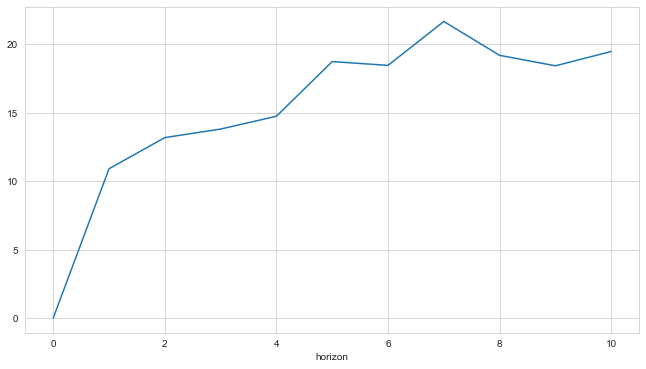

In [116]:
results.groupby('horizon').error.mean().loc[0:].plot()


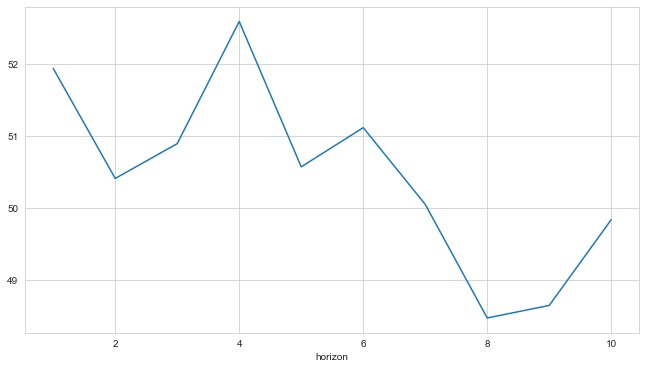

In [118]:
results.groupby('horizon').absolute_error.mean().loc[1:].plot()